In [68]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
%config InlineBackend.figure_formats = ['jpg']

from scipy import interpolate
from scipy import integrate

from ipywidgets import interact
import ipywidgets as widgets

In [2]:
plt.rcdefaults()
plt.rcParams.update({'figure.dpi':100})
#plt.rcParams.update({'figure.autolayout':'True'})
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'font.family': 'sans-serif'})
plt.rcParams.update({'mathtext.default':'regular'})
plt.rcParams.update({'mathtext.fontset':'stixsans'})
plt.rcParams.update({'axes.linewidth': 1.5})
plt.rcParams.update({'xtick.major.width': 1.25 })
plt.rcParams.update({'xtick.minor.size': 2.5})
plt.rcParams.update({'xtick.minor.width': 1.25 })
plt.rcParams.update({'ytick.major.size': 5})
plt.rcParams.update({'ytick.major.width': 1.25 })
plt.rcParams.update({'ytick.minor.size': 2.5})
plt.rcParams.update({'ytick.minor.width': 1.25 })
plt.rc('legend',**{'fontsize':'x-small'})
#plt.figure(1,figsize = [11.0, 8.5])
plt.rcParams.update({'xtick.direction':'in'})
plt.rcParams.update({'ytick.direction':'in'})
plt.rcParams.update({'xtick.top':'True'})
plt.rcParams.update({'ytick.right':'True'})
#plt.rcParams.update({'axes.formatter.limits': (-2, 2)})
plt.rcParams.update({'lines.markersize': 8}) #6 is the default
plt.rcParams.update({'legend.framealpha': 1.0})
plt.rcParams.update({'legend.fancybox': 'False'})
plt.rcParams.update({'axes.grid':'True'})

In [3]:
# Global variables
Percentages = [0.6827, 0.9545]

In [69]:
def get_levels(loglike):
    ds = np.sort(np.exp(-0.5*loglike).flatten())[::-1]
    cs = np.cumsum(ds)
    cs /= cs[-1]
    return np.array([ds[np.argmax(cs > l)] for l in Percentages])[::-1]

alpha = 2
betay = 0
gammax = 0
gammay = 1.5
const = 0

@interact(betax= widgets.FloatSlider(min=-5, max=5), 
          theta= widgets.FloatSlider(min=0, max=np.pi/2))

def plot_like(betax, theta):
    xyrange = (-10,10)
    x_base, y_base = np.meshgrid(*2*[np.linspace(*xyrange, 1000)])
    
    x = x_base*np.cos(theta) + y_base*np.sin(theta)
    y = -x_base*np.sin(theta) + y_base*np.cos(theta)

    loglike = x**2 + y**2 + np.exp(alpha)*(betax*x**2 + betay*y**2 - gammax*x - gammay*y + const)**2

    plt.gca().set_aspect(1)
    plt.contour(np.exp(-0.5*loglike), extent=2*xyrange, levels=get_levels(loglike))
    plt.xlim((-3,3))
    plt.ylim((-3,3))
    

interactive(children=(FloatSlider(value=0.0, description='betax', max=5.0, min=-5.0), FloatSlider(value=0.0, d…

In [5]:
def normalize(l, x):
    raw_sum = np.trapz(l, x)
    return l/raw_sum

# marginalize over param y for axis = 0,
#                        x for axis = 1
# a denotes x or y
def marginalize(L, a, axis):
    l_axis = np.sum(L, axis=axis)
    l_normed = normalize(l_axis, a)
    return l_normed

# maximize over param y
def maximize(L, x, y, mean_y):
    pos = np.where(y==mean_y)[0][0]
    l = L[pos]
    return normalize(l, x)

In [39]:
def get_mu_sigma(L, x):
    f = interpolate.interp1d(x, L)
    x_new = np.linspace(np.min(x), np.max(x), 10000)
    y_new = f(x_new)
    mu = np.average(x, weights=L)
    sigma = np.sqrt(np.average((x-mu)**2, weights=L))
    return mu, sigma

In [7]:
Alpha = 2
Betaxs = np.linspace(-5, 5, 101)
Gammay = 1.5
Theta = 0.2

xyrange = (-10,10)
X, Y = np.meshgrid(*2*[np.linspace(*xyrange, 1001)])
#x_base, y_base = np.meshgrid(*2*[np.linspace(*xyrange, 1000)])
    
X_b = X*np.cos(Theta) + Y*np.sin(Theta)
Y_b = -X*np.sin(Theta) + Y*np.cos(Theta)

x = X[0]
y = Y.T[0]

#x_b = x_base[0]
#y_b = y_base.T[0]

Log_Likelihoods = []

for i in range(len(Betaxs)):
    Betax = Betaxs[i]
    loglike = X_b**2 + Y_b**2 + np.exp(Alpha)*(Betax*X_b**2 - Gammay*Y_b)**2
    Log_Likelihoods.append(loglike)

Likelihoods is a set of 101 likelihood distributions for different $\beta_x$ values

In [33]:
l = Log_Likelihoods[np.argmax(Betaxs==0)]
l1 = Log_Likelihoods[np.argmax(Betaxs>=0.5)]

L = np.exp(-0.5*l)
L1 = np.exp(-0.5*l1)

$\mathcal{L}$ is the log likelihood surface for $\beta_x=0$, i.e. a Gaussian likelihood surface.

$\mathcal{L}_1$ is the log likelihood surface for $\beta_x=0.5$.

Assume from now on that y is the nuisance parameter that we integrate over (avoid binodality). To implement equation 7, we need to take the derivate of $\mathcal{L}$ with repect to $y$.

In [34]:
def get_tk_marg(loglike):
    dL = np.gradient(loglike, y, axis=0, edge_order=2)
    ddL = np.gradient(dL, y, axis=0, edge_order=2)

    L_marg = loglike - 0.5*dL*(1/ddL)*dL + np.log(0.5*ddL)

    # fig, ax = plt.subplots(1, 1)
    # cset = ax.contour(X, Y, L_marg)
    # ax.set_aspect('equal')
    # plt.clabel(cset, inline=True)
    # ax.set_xlabel('x')
    # ax.set_ylabel(r'$y_0$')
    return normalize(np.exp(-0.5*L_marg)[Y==0], x)

In [35]:
L_tk_marg = get_tk_marg(l)

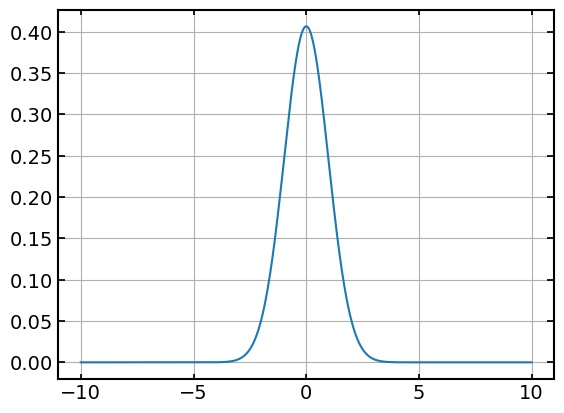

In [36]:
plt.plot(x, L_tk_marg)

In [37]:
mu, sigma = get_mu_sigma(L_tk_marg, x)
print(mu)

-0.0010001000100015034


In [38]:
np.average(x, weights=L_tk_marg)

1.2789769243681803e-15

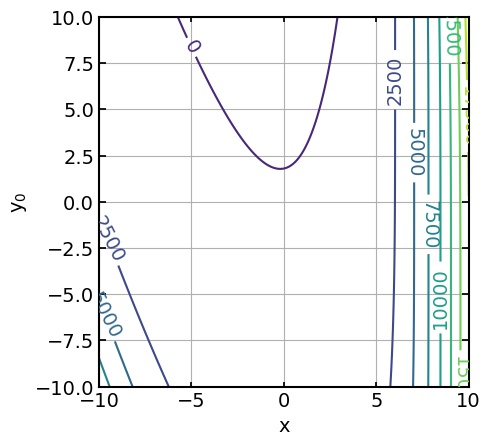

In [13]:
L1_tk_marg = get_tk_marg(l1)

Odd behaviour for larger $\beta_x$ values.

/tmp/ipykernel_4631/854239433.py:5: RuntimeWarning: invalid value encountered in log
  L_marg = loglike - 0.5*dL*(1/ddL)*dL + np.log(0.5*ddL)
/tmp/ipykernel_4631/854239433.py:13: RuntimeWarning: overflow encountered in exp
  return normalize(np.exp(-0.5*L_marg)[Y==0], x)


array([0., 0., 0., ..., 0., 0., 0.])

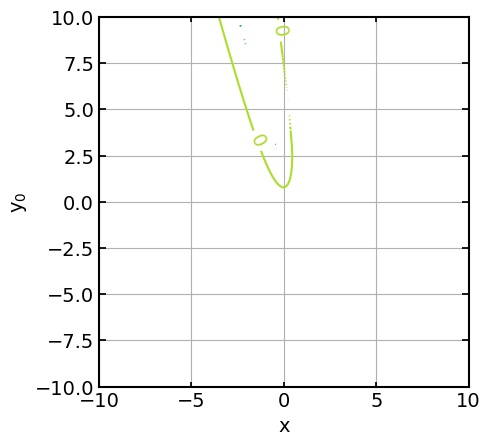

In [12]:
get_tk_marg(Log_Likelihoods[np.argmax(Betaxs>=4)])

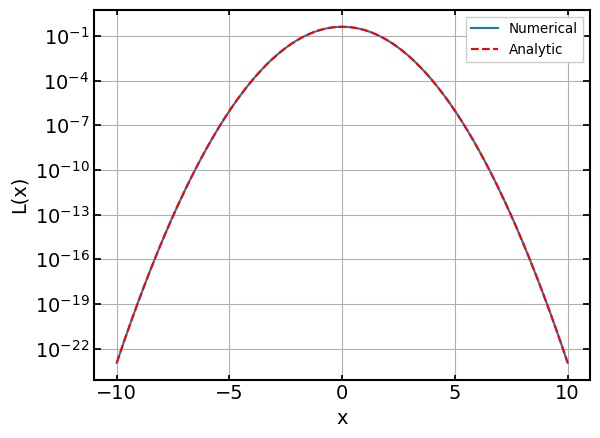

In [16]:
L_marg = marginalize(L, y, 0)
L_tk_marg_normed = normalize(L_tk_marg, x)
fig, ax = plt.subplots(1, 1)
ax.plot(x, L_marg, label='Numerical')
ax.plot(x, L_tk_marg_normed, 'r--', label='Analytic')
ax.set_xlabel('x')
ax.set_ylabel('L(x)')
ax.set_yscale('log')
ax.legend()

In [17]:
def get_levels(likelihood, percentages):
    l_flatten = likelihood.flatten()
    l_flatten.sort()
    l_dec = l_flatten[::-1]
    l_tot = np.sum(l_dec)
    levels = []
    l_sum = 0
    i = -1
    for percentage in percentages:
        while((l_sum/l_tot)<percentage):
            i += 1
            l_sum += l_dec[i]
        levels.append(l_dec[i])
    return levels[::-1]

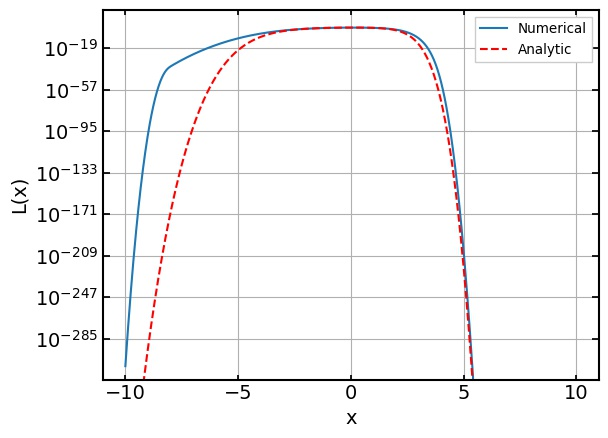

In [18]:
L1_marg = marginalize(L1, y, 0)
L1_tk_marg_normed = normalize(L1_tk_marg, x)
fig, ax = plt.subplots(1, 1)
ax.plot(x, L1_marg, label='Numerical')
ax.plot(x, L1_tk_marg_normed, 'r--', label='Analytic')
ax.set_xlabel('x')
ax.set_ylabel('L(x)')
ax.set_yscale('log')
ax.legend()

/tmp/ipykernel_4844/3783483941.py:5: RuntimeWarning: invalid value encountered in log
  L_marg = loglike - 0.5*dL*(1/ddL)*dL + np.log(0.5*ddL)
/tmp/ipykernel_4844/3783483941.py:13: RuntimeWarning: overflow encountered in exp
  return normalize(np.exp(-0.5*L_marg)[Y==0], x)


Text(0.5, 1.0, 'Marginalized likelihood centered at y=0')

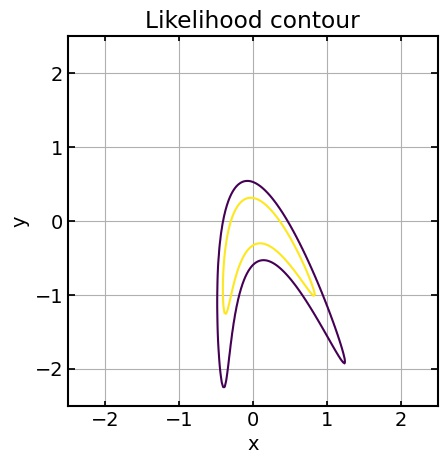

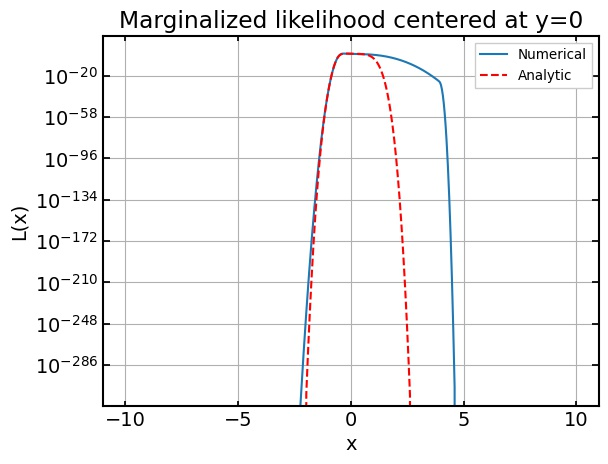

In [56]:
l0 = Log_Likelihoods[4]
L0 = np.exp(-0.5*l0)
plt.gca().set_aspect(1)
plt.contour(x, y, L0, levels=get_levels(L0, Percentages))
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Likelihood contour')
L0_tk_marg = get_tk_marg(l0)
L0_marg = marginalize(L0, y, 0)
L0_tk_marg_normed = normalize(L0_tk_marg, x)
fig, ax = plt.subplots(1, 1)
ax.plot(x, L0_marg, label='Numerical')
ax.plot(x, L0_tk_marg_normed, 'r--', label='Analytic')
ax.set_xlabel('x')
ax.set_ylabel('L(x)')
ax.set_yscale('log')
ax.legend()
ax.set_title('Marginalized likelihood centered at y=0')

In [24]:
def get_tk_marg(loglike):
    dL = np.gradient(loglike, y, axis=0, edge_order=2)
    ddL = np.gradient(dL, y, axis=0, edge_order=2)

    L_marg = loglike - 0.5*dL*(1/ddL)*dL + np.log(0.5*ddL)
    return np.exp(-0.5*L_marg)[Y==0]

In [45]:
diff_mu = []
Mu = []
Mu_tk = []
Sigma = []
Sigma_tk = []
Var = []
for i in range(len(Log_Likelihoods)):
    l = Log_Likelihoods[i]
    L = np.exp(-0.5*l)
    L_tk_marg = normalize(get_tk_marg(l), x)
    mu_tk, sigma_tk = get_mu_sigma(L_tk_marg, x)
    
    L_marg = marginalize(L, y, 0)
    mu, sigma = get_mu_sigma(L_marg, x)
    
    diff_mu.append(mu_tk-mu)
    Mu.append(mu)
    Mu_tk.append(mu_tk)
    Sigma.append(sigma)
    Sigma_tk.append(sigma_tk)

/tmp/ipykernel_4844/3783483941.py:5: RuntimeWarning: invalid value encountered in log
  L_marg = loglike - 0.5*dL*(1/ddL)*dL + np.log(0.5*ddL)
/tmp/ipykernel_4844/3783483941.py:13: RuntimeWarning: overflow encountered in exp
  return normalize(np.exp(-0.5*L_marg)[Y==0], x)


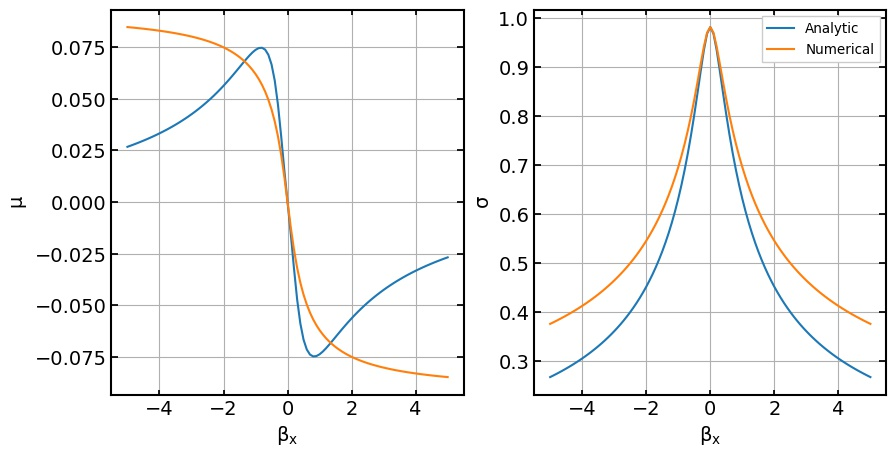

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(Betaxs, np.array(Mu_tk), label='Analytic')
ax[0].plot(Betaxs, np.array(Mu), label='Numerical')
ax[0].set_xlabel(r'$\beta_x$')
ax[0].set_ylabel(r'$\mu$')
ax[1].plot(Betaxs, np.array(Sigma_tk), label='Analytic')
ax[1].plot(Betaxs, np.array(Sigma), label='Numerical')
ax[1].set_xlabel(r'$\beta_x$')
ax[1].set_ylabel(r'$\sigma$')
ax[1].legend()

What if we only keep the positive parts

In [65]:
Alpha = 2
Betax = 1
Gammay = 1.5
Theta = 0.2

xyrange = (-5,10)
X, Y = np.meshgrid(*2*[np.linspace(*xyrange, 1001)])
#x_base, y_base = np.meshgrid(*2*[np.linspace(*xyrange, 1000)])
    
X_b = X*np.cos(Theta) + Y*np.sin(Theta) -0.1
Y_b = -X*np.sin(Theta) + Y*np.cos(Theta) -0.1

x = X[0]
y = Y.T[0]

#x_b = x_base[0]
#y_b = y_base.T[0]

loglike = X_b**2 + Y_b**2 + np.exp(Alpha)*(Betax*X_b**2 - Gammay*Y_b)**2

In [ ]:
np.exp(-0.5*L_marg)[Y==0]

/tmp/ipykernel_4844/3783483941.py:5: RuntimeWarning: invalid value encountered in log
  L_marg = loglike - 0.5*dL*(1/ddL)*dL + np.log(0.5*ddL)
/tmp/ipykernel_4844/3783483941.py:13: RuntimeWarning: overflow encountered in exp
  return normalize(np.exp(-0.5*L_marg)[Y==0], x)


ValueError: operands could not be broadcast together with shapes (1000,) (0,) 

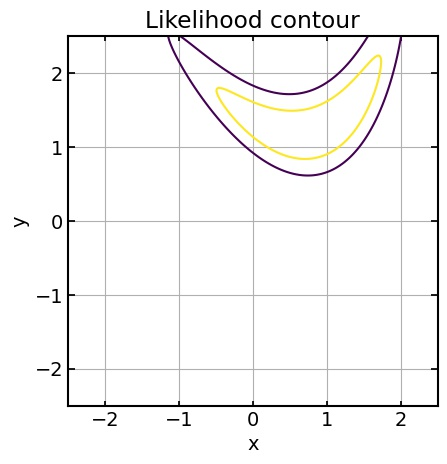

In [64]:
L = np.exp(-0.5*loglike)
plt.gca().set_aspect(1)
plt.contour(x, y, L, levels=get_levels(L, Percentages))
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Likelihood contour')
L_tk_marg = get_tk_marg(loglike)
L_marg = marginalize(L, y, 0)
L_tk_marg_normed = normalize(L_tk_marg, x)
fig, ax = plt.subplots(1, 1)
ax.plot(x, L_marg, label='Numerical')
ax.plot(x, L_tk_marg_normed, 'r--', label='Analytic')
ax.set_xlabel('x')
ax.set_ylabel('L(x)')
ax.set_yscale('log')
ax.legend()
ax.set_title('Marginalized likelihood centered at y=0')